# Анализ данных фитнес-клуба

Необходимо провести анализ и подготовить план действий по удержанию клиентов:

- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    * выделить целевые группы клиентов;
    * предложить меры по снижению оттока;
    * определить другие особенности взаимодействия с клиентами.

### План

1. Загрузка данных


2. Исследовательский анализ данных (EDA)


3. Построение модели прогнозирования оттока пользователей


4. Кластеризация пользователей


5. Выводы и рекомендации


### Описание данных

Путь к файлу: **`/datasets/gym_churn.csv`**

Датасет содержит данные на месяц до оттока и факт оттока на определённый месяц.

- *'Churn'* — факт оттока в текущем месяце;

Данные пользователя за предыдущий до проверки факта оттока месяц:

- *'gender'* — пол
- *'Near_Location'* — проживание или работа в районе, где находится фитнес-центр
- *'Partner'* — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- *'Promo_friends'* — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- *'Phone'* — наличие контактного телефона
- *'Age'* — возраст
- *'Lifetime'* — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента

- *'Contract_period'* — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- *'Month_to_end_contract'* — срок до окончания текущего действующего абонемента (в месяцах)
- *'Group_visits'* — факт посещения групповых занятий
- *'Avg_class_frequency_total'* — средняя частота посещений в неделю за все время с начала действия абонемента
- *'Avg_class_frequency_current_month'* — средняя частота посещений в неделю за предыдущий месяц
- *'Avg_additional_charges_total'* — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

## 1. Загрузка данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# импортируем разметку markdown
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("white") # стиль графиков в отчете

In [2]:
# загружаем датасет
gym_churn = pd.read_csv('datasets/gym_churn.csv')

## 2. Исследовательский анализ данных (EDA)

Изучим полученный датасет.

In [3]:
# выводим информацию о датасете
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В датасете содержится 4000 записей. Пропуски отсутствуют, типы данных соответствуют хранящимся значениям.

Тип признаков - числовой.

In [4]:
# выводим описание датасета
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Изучим средние значения признаков в двух группах - отток и оставшихся. 

In [5]:
gym_churn.groupby('Churn').agg('mean')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


В среднем, люди оставшиеся в клубе занимаются дольше ушедших, часть из них является сотрудниками компаний-партнеров, а так же чаще посещает групповые занятия. В среднем, в отток идут люди после одного месяца, они реже посещают групповые занятия и реже являются сотрудниками компаний-партнеров. 

Построим столбчатые гистограммы и распределения признаков для двух групп - "отток" и "оставшиеся клиенты"

<center><i><font size=3>Рисунок 1. Гистограммы и распределения признаков</font></i></center>

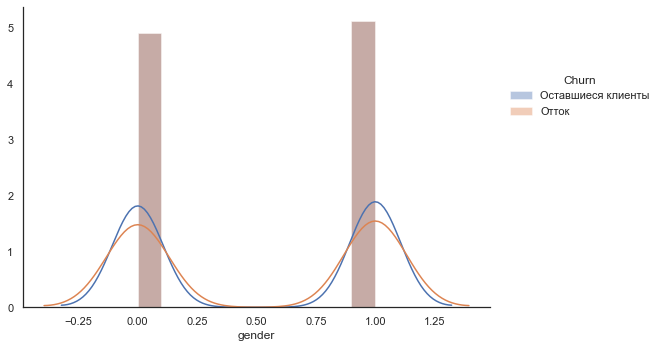

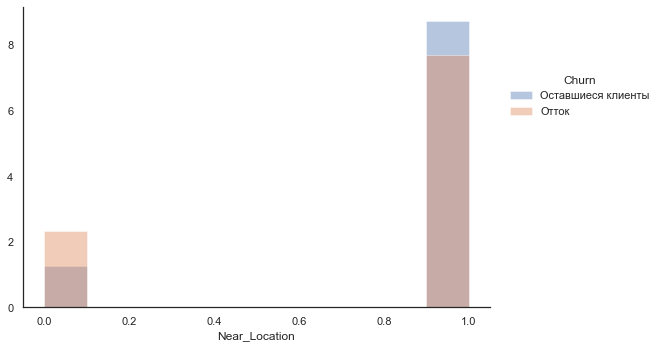

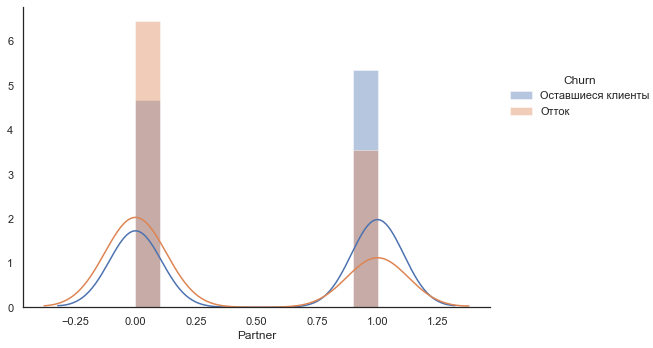

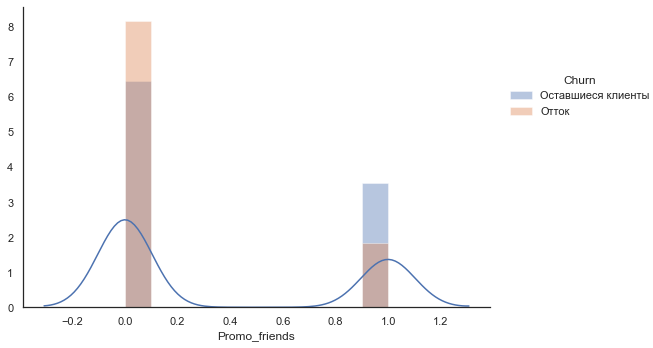

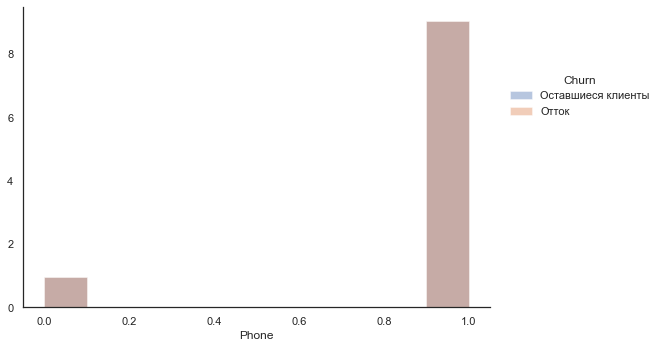

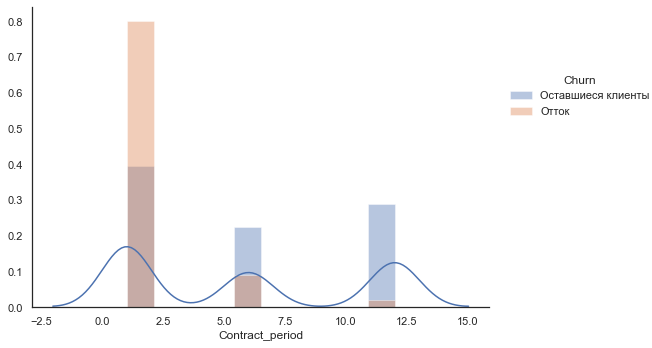

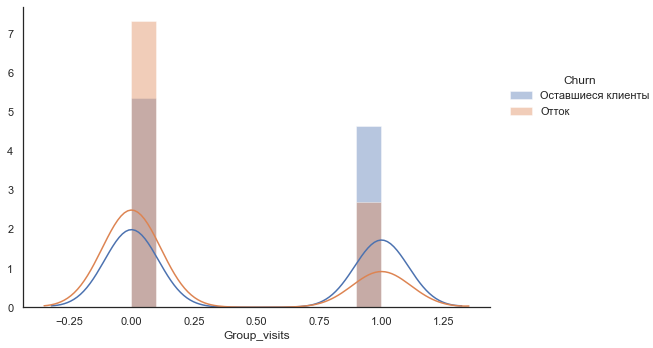

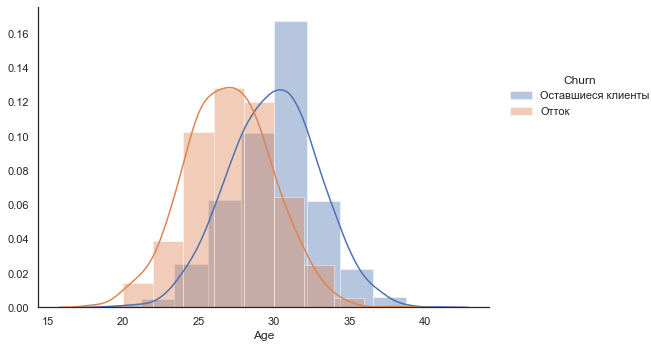

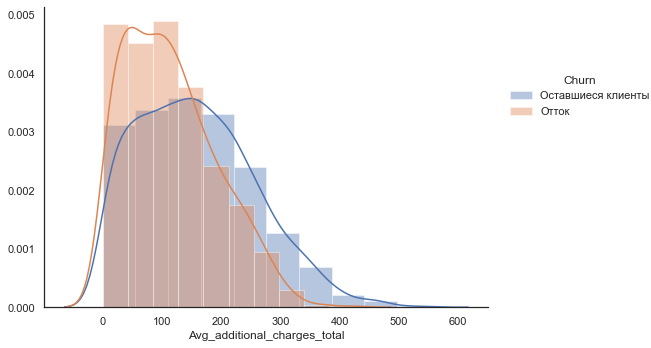

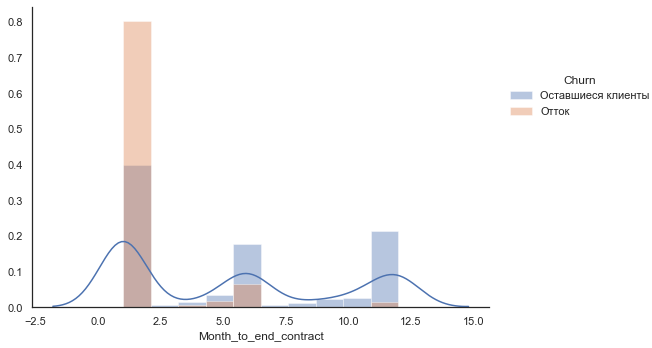

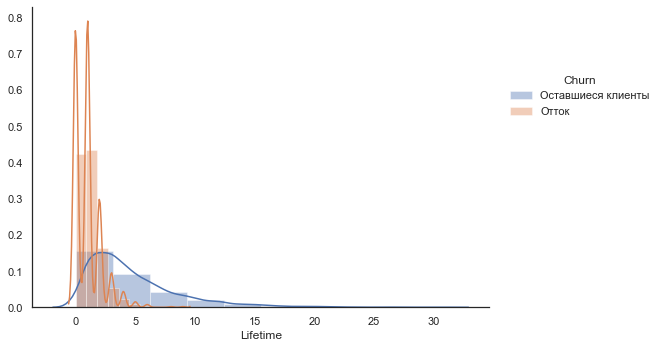

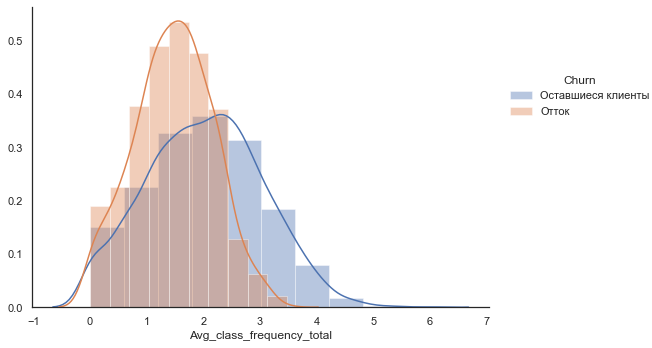

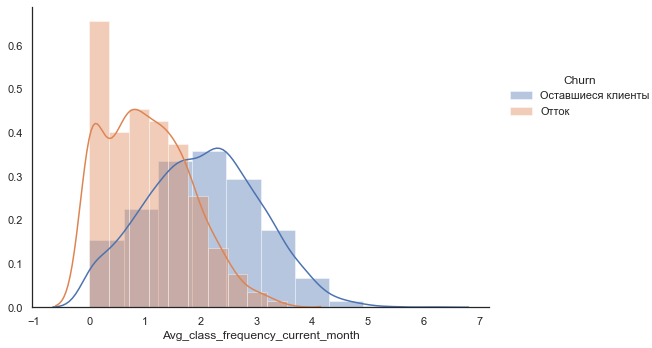

In [6]:
# задаем отрисовку в цикле
printmd("<center><i><font size=3>Рисунок 1. Гистограммы и распределения признаков</font></i></center>")
for feature in gym_churn.drop('Churn', axis=1).columns:
    g = sns.FacetGrid(gym_churn, hue='Churn', height=5, aspect=1.4)#, legend_out=True)
    g.map(sns.distplot, feature, bins=10).add_legend()
    for t, l in zip(g._legend.texts,("Оставшиеся клиенты", "Отток")):
        t.set_text(l)
    g._legend.set_bbox_to_anchor([1.2,0.7]);

Распределения не нормальные, требуют стандартизации. 

Клиенты, уходящие в отток чаще заключают договоры на 1-2 месяца, реже посещают групповые занятия. В среднем, они младше на несколько лет, чем оставшиеся клиенты. Также, платят меньшие суммы за сопутствующие услуги.

Построим матрицу корреляций.

In [7]:
# рассчитаем матрицу корреляции
cm = gym_churn.corr()

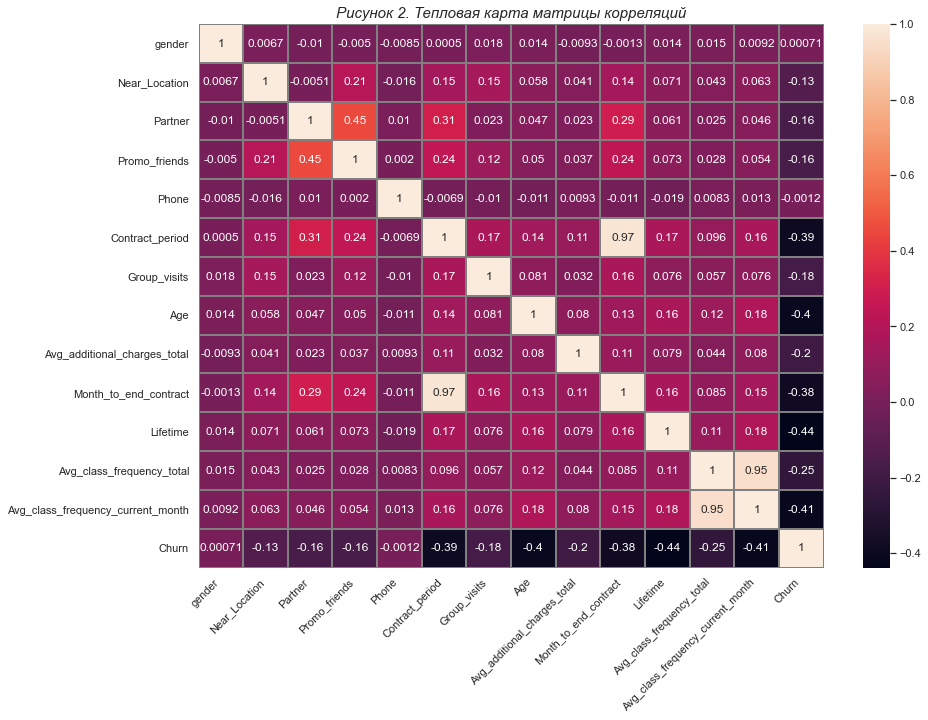

In [8]:
# отрисовываем матрицу
sns.set(style='white')
plt.figure(figsize=(14, 10))
plt.title('Рисунок 2. Тепловая карта матрицы корреляций', fontsize=15, style="italic")
ax = sns.heatmap(cm, annot=True, linewidths=1, linecolor='gray')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment="right")
ax.set_ylim(14, 0);

Судя по матрице корреляций, особое внимание стоит обратить на признаки: длительность контракта, возраст, среднее количество посещений в неделю за предыдущий месяц

### Выводы

Датасет содержит 4000 записей. Пропуски отсутствуют, типы данных соответствуют хранящимся значениям.
Тип признаков - числовой.

Целевая переменная не имеет временную структуру.

В среднем, люди оставшиеся в клубе занимаются дольше ушедших, часть из них является сотрудниками компаний-партнеров, а так же чаще посещает групповые занятия. В среднем, в отток идут люди после одного месяца, они реже посещают групповые занятия и реже являются сотрудниками компаний-партнеров. 

Клиенты, уходящие в отток чаще заключают договоры на 1-2 месяца, реже посещают групповые занятия. В среднем, они младше на несколько лет, чем оставшиеся клиенты. Также, платят меньшие суммы за сопутствующие услуги.

Судя по матрице корреляций, особое внимание стоит обратить на признаки: длительность контракта, возраст, среднее количество посещений в неделю за предыдущий месяц

## 3. Построение модели прогнозирования оттока пользователей

Разделим данные на признаки и целевую переменную.

In [9]:
# признаки
X = gym_churn.drop('Churn', axis=1)

# целевая переменная
y = gym_churn['Churn']

Разделим модель на обучающую и валидационную выборки. 

In [10]:
# делим на группы 80 к 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

Стандартизируем данные. 

In [11]:
# обучаем на тренировочной выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [12]:
# стандартизируем выборки
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Зададим алгоритмы и проведем моделирование

In [13]:
# формируем список моделей
model_list = {'Логистическая регрессия (LogisticRegression)': LogisticRegression,
              'Случайный лес (RandomForestClassifier)': RandomForestClassifier}

# моделируем
for model_name, model_ in model_list.items():
    
    if model_ == RandomForestClassifier:
        model = model_(random_state=0, n_estimators=100)
    
    else:
        model = model_(random_state=0, solver='lbfgs')
    
    model.fit(X_train_st, y_train)
    
    prediction = model.predict(X_test_st)
    
    print('Метрики для модели {}:'.format(model_name))
    print('\tAccuracy: {:.3f}'.format(accuracy_score(y_test, prediction)))
    print('\tPrecision: {:.3f}'.format(precision_score(y_test, prediction)))
    print('\tRecall: {:.3f}'.format(recall_score(y_test, prediction)))
    print()

Метрики для модели Логистическая регрессия (LogisticRegression):
	Accuracy: 0.922
	Precision: 0.854
	Recall: 0.828

Метрики для модели Случайный лес (RandomForestClassifier):
	Accuracy: 0.915
	Precision: 0.839
	Recall: 0.813



### Выводы

В данном случае лучше себя показала модель логистической регрессии (LogisticRegression). 

Показатели метрик:
- Accuracy: 0.922
- Precision: 0.854
- Recall: 0.828

## 4. Кластеризация пользователей

Стандартизируем набор признаков.

In [14]:
# стандартизация
X_sc = scaler.fit_transform(X)

# таблица связок
linked = linkage(X_sc, method = 'ward')

Построим матрицу расстояний

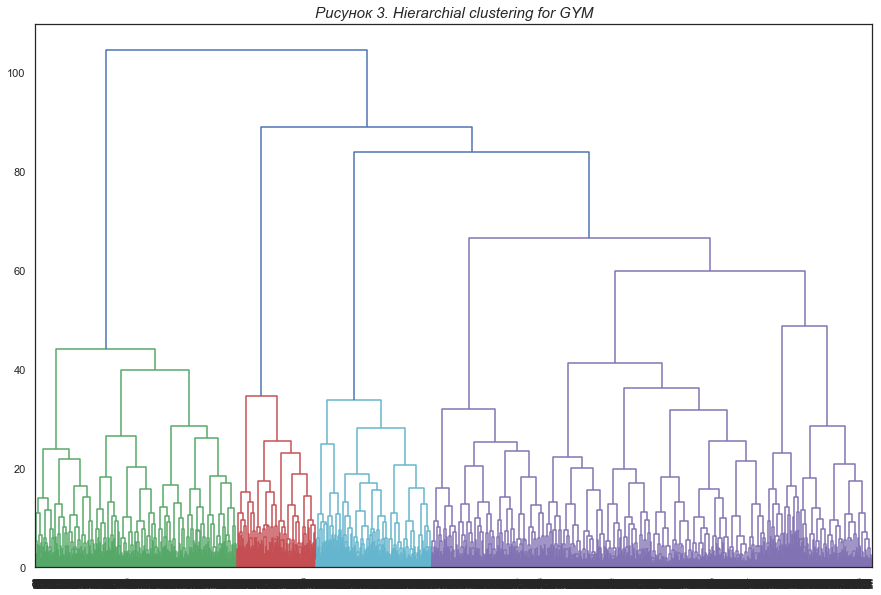

In [15]:
# строим матрице расстояний
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Рисунок 3. Hierarchial clustering for GYM', fontsize=15, style="italic")
plt.show()

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

Исходя из дендрограммы, стоит взять число кластеров, равным 4.

Однако, по заданию, принимаем число кластеров == 5. 

In [16]:
# задаем модель
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры
labels = km.fit_predict(X_sc)

In [17]:
# сохраняем метки кластера в поле датасета
gym_churn['cluster'] = labels

In [18]:
# статистика по средним значениям признаков по кластеру
mean_values_by_cluster = gym_churn.groupby('cluster').agg('mean').sort_values('Churn', ascending=False)

# подпись групп, чтобы при написании рекомендаций и выводов использовать их
mean_values_by_cluster['labels'] = ['Alpha', 'Beta', 'Delta', 'Charlie','Echo']

# присоединяем подписи групп к набору
gym_churn = gym_churn.merge(mean_values_by_cluster[['labels']], 
                            left_on='cluster', 
                            right_on=mean_values_by_cluster.index)

In [19]:
# выводим статистику по средним значениям признаков по кластеру
mean_values_by_cluster

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,labels
cluster,,,,,,,,,,,,,,,
1,0.480300,0.812383,0.000000,0.086304,1.000000,1.863039,0.324578,28.136961,131.299377,1.787992,2.346154,1.325794,1.086387,0.550657,Alpha
3,0.509603,0.750320,1.000000,0.451985,1.000000,2.554417,0.303457,28.499360,129.812508,2.370038,2.832266,1.355379,1.176172,0.395647,Beta
0,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532,Delta
2,0.560096,0.858173,0.337740,0.197115,0.998798,2.734375,0.449519,30.204327,164.628354,2.522837,5.007212,2.926304,2.932554,0.048077,Charlie
4,0.495726,0.943376,0.752137,0.541667,1.000000,11.352564,0.564103,29.993590,164.563799,10.376068,4.817308,2.028169,2.020129,0.023504,Echo


<center><i><font size=3>Рисунок 4. Распределения признаков для кластеров</font></i></center>

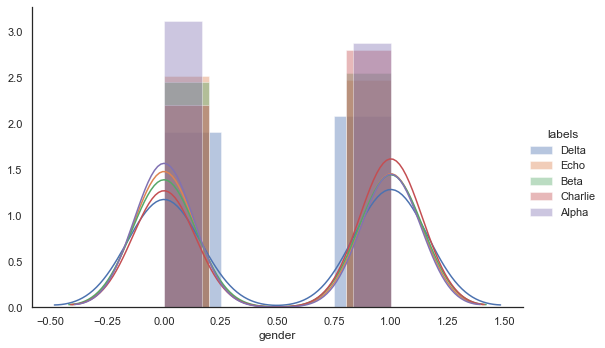

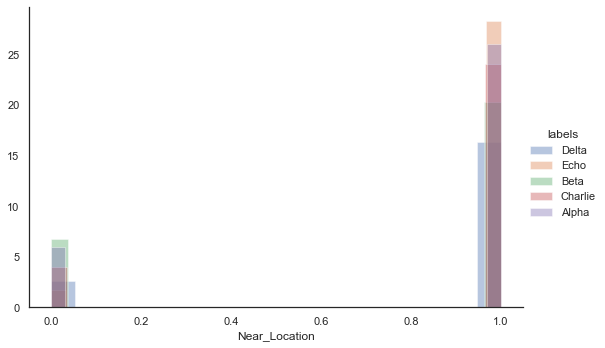

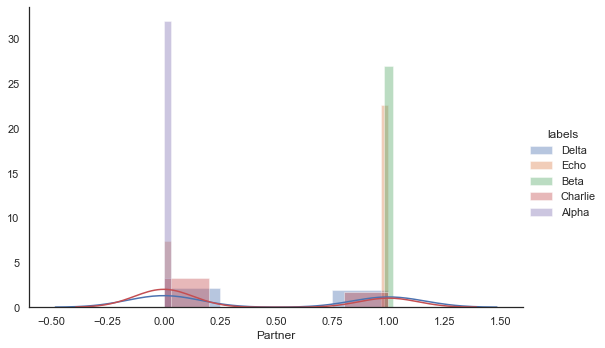

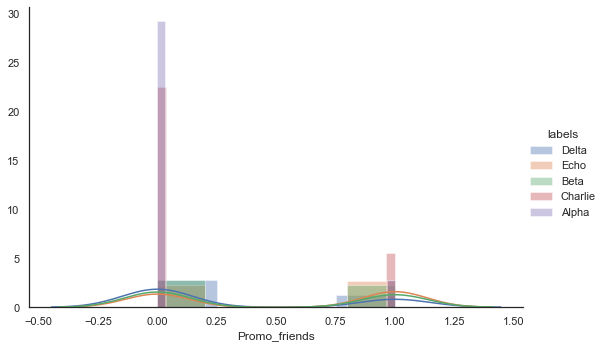

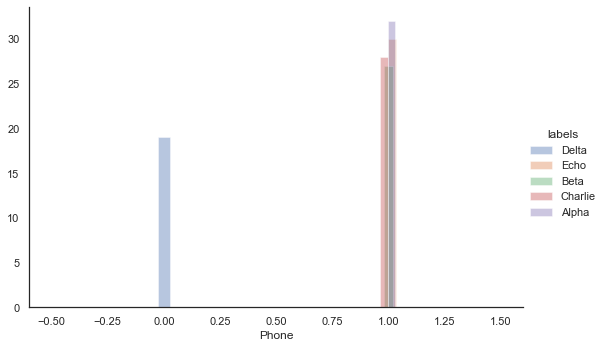

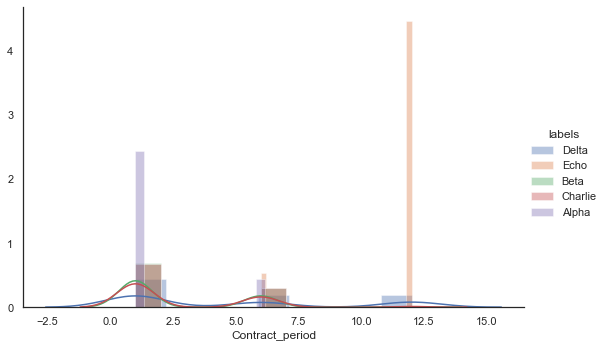

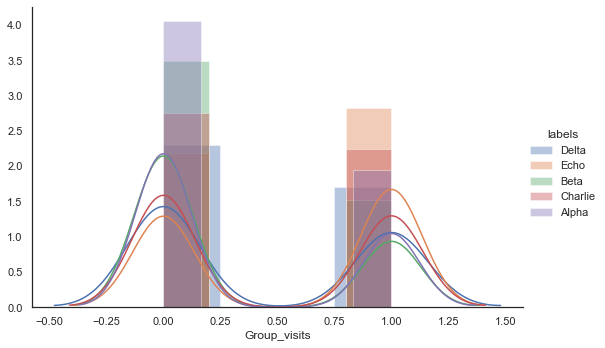

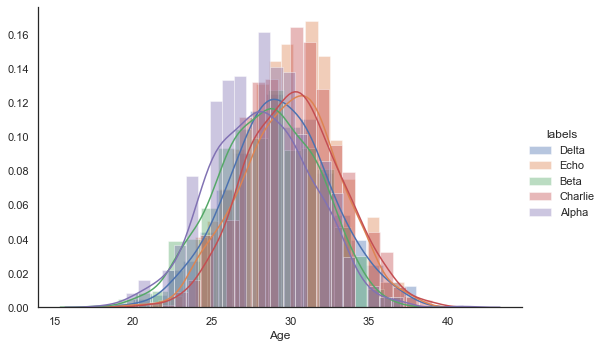

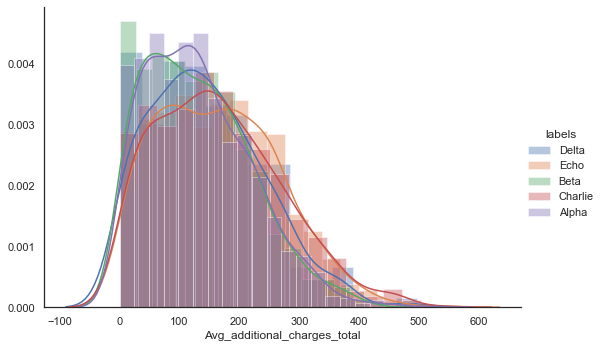

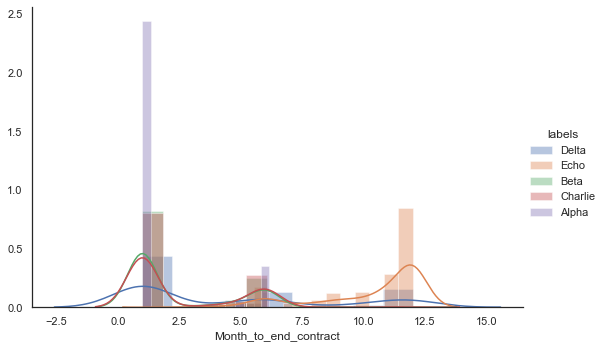

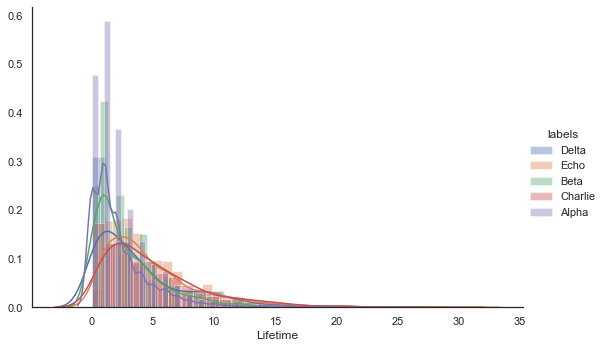

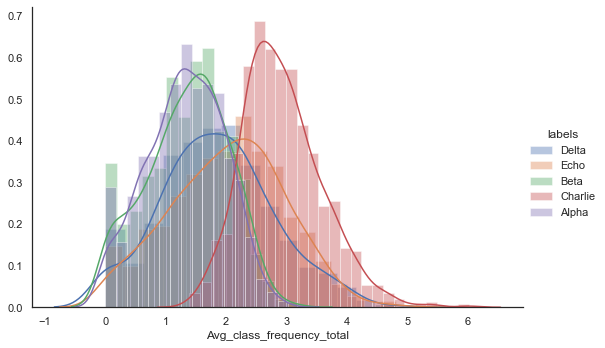

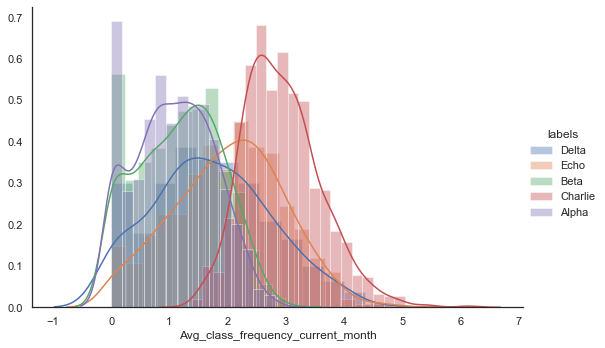

In [20]:
# задаем отрисовку в цикле
printmd("<center><i><font size=3>Рисунок 4. Распределения признаков для кластеров</font></i></center>")
for feature in gym_churn.drop(['Churn', 'cluster', 'labels'], axis=1).columns:
    g = sns.FacetGrid(gym_churn.drop(['Churn', 'cluster'], axis=1), 
                      hue='labels', 
                      height=5, 
                      aspect=1.5)
    g.map(sns.distplot, feature).add_legend();

In [21]:
gym_churn.groupby('cluster')\
    .agg({'Churn': 'mean', 'labels': 'max'})\
    .round(3)\
    .sort_values('Churn', ascending=False)

,Churn,labels
cluster,,
1,0.551,Alpha
3,0.396,Beta
0,0.268,Delta
2,0.048,Charlie
4,0.024,Echo


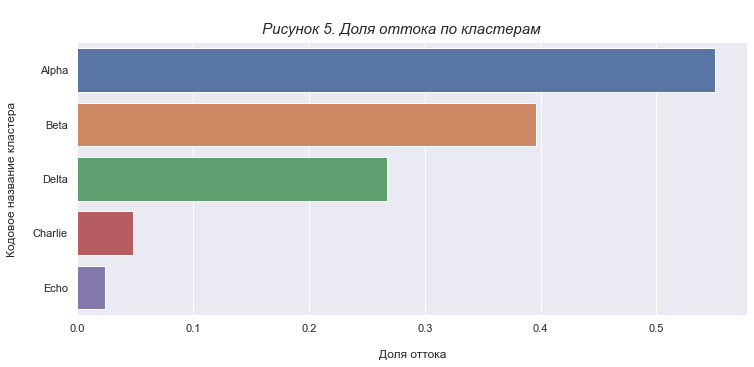

In [22]:
# строим график
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('\nРисунок 5. Доля оттока по кластерам', fontsize=15, style="italic")

# отрисовываем график
sns.barplot(y='labels',
            x='Churn',
            data=gym_churn.groupby('cluster').agg({'Churn': 'mean', 'labels': 'max'})\
                .sort_values('Churn', ascending=False))

sns.despine(left=True, bottom=True)

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['xtick.minor.visible'] = True

ax.set_ylabel('Кодовое название кластера\n')
ax.set_xlabel('\nДоля оттока');

Можно выделить несколько групп по долям оттока:

Группа клиентов с наименьшей долей оттока. Суммы покупок часто доходят до 300 рублей и выше. Чаще всего оформляют длительные контракты, возраст - старше или около 30. Чаще всего являются сотрудниками компаний-партнеров. Посещают занятия в среднем 2 раза в месяц и чаще

Группа со средней вероятностью оттока - посещают занятия менее двух раз, длительность контракта редко превышает 3 месяца, размер покупок дополнительных услуг - не более 200 рублей, возраст - от 25 до 30 лет. 

Группа с наибольшей долей оттока. Клиенты из этой группы редко посещают зал (1-2 раза в месяц - перед оттоком распределение смещается в сторону нуля). Возраст таких клиентов часто находится в районе 25 лет. Они оформляют краткосрочные контракты и почти не тратят деньги на сопутствующие услуги. 

## 5. Выводы и рекомендации

### Выводы

Проведен исследовательский анализ данных. Данные полные, не имеют пропусков. Распределения не нормальные и требовали стандартизации. 

Стандартизация проведена при помощи StandardScaler из модуля sklearn.preprocessing

Построены модели прогнозирования оттока пользователей. Моделирование проведено с использованием моделей _Логистическая регрессия (LogisticRegression)_ и _случайный лес (RandomForestClassifier)_. Лучше себя проявила модель _LogisticRegression_.

Проведена кластеризация пользователей. Исходя из построенной дендрограммы, число кластеров - 4. Однако, в соответствии с учебным заданием было использовано число кластеров == 5.

Выделены и описаны характерные группы клиентов фитнес-клуба по доле оттока. 

### Рекомендации

Стоит задуматься над удержанием аудитории 25 лет и младше. Возможно, краткосрочные контракты объясняются высокой ценой на годовой контракт. Рекомендовал бы ввести акции со скидками для студентов, школьником и т.п. Также, возможно, клиенты группы моложе 25 лет не имеют возможности приобретать дополнительные услуги или цена на них слишком высокая. Стоит также задуматься над системой дисконтирования.

Стоит сосредоточиться на увеличении количества клиентов из наиболее лояльной группы - 30 и старше. Так как основной доход (от длительных контрактов и больших трат на сопутствующие услуги) приносят они.

Возможно, необходимо вести обзвон клиентов либо каким-то другими способами напоминать ему о том, что он давно не ходил в клуб - так у клиента будет вырабатываться привычка к посещению и он будет продлевать свой абонемент дальше.